In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import norm

from libs.pipeline import *
from libs.visualizations import *
from libs.sfno import SFNO
from libs.finetune import OutConvFT
from torch.utils.data import DataLoader
from libs.visualizations import *

get_seed(42, printout=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dtype = torch.float64
torch.set_default_dtype(dtype)


Loading modules for visualization - done in 0.541477 seconds. 



In [2]:

VAL_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_fp32_64x64_N1152_v1e-3_T100.pt"
)
TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_fp64_256x256_N16_v1e-3_T100.pt"
)

Ntrain = 1024
Ntest = 16
Nval = 64

batch_size = 1

epochs = 15
learning_rate = 0.01

n = 256
nc = 64
T = 10
fields = ["vorticity", "stream", "residual", "vort_t"]
fs = 'vorticity'
beta = -1e-2

modes = 32
modes_t = 5
width = 10

model_name = f"sfno_ex2_N{Ntrain}_ep{epochs}_m{modes}_w{width}.pt"

path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)

sfno_ex2_N1024_ep15_m32_w10.pt


In [3]:
val_dataset = BochnerDataset(datapath=VAL_PATH, 
                              fields=fields,
                              n_samples=Nval,
                              steps=T,
                              T_start=50,
                              dtype=dtype,
                              train=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = BochnerDataset(datapath=TEST_PATH, 
                              fields=fields,
                              n_samples=Ntest,
                              steps=T,
                              T_start=50,
                              dtype=dtype,
                              train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [4]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta).to(device)
print(get_num_params(model))

model.load_state_dict(torch.load(path_model))
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)
loss_func_64 = SobolevLoss(n_grid=nc, norm_order=0, time_average=True, relative=True)
val_l2 = eval_epoch_ns(model, loss_func_64, val_loader, device)
test_l2 = eval_epoch_ns(model, loss_func, test_loader, device)


print(f"Test L2 on {nc}x{nc}: {val_l2:.5e}")
print(f"Test L2 on {n}x{n}: {test_l2:.5e}")

16474521
Test L2 on 64x64: 5.69167e-02
Test L2 on 256x256: 1.17564e-01


In [5]:
idx = 2
sample = test_dataset.__getitem__(idx = idx, start_steps=50)
vort_inp_gt, vort_out_gt = sample[0]['vorticity'], sample[1]['vorticity']
vort_inp_gt = vort_inp_gt.unsqueeze(0).to(device)
vort_out_gt = vort_out_gt.unsqueeze(0).to(device)

model.eval()
model.add_latent_hook("r")
with torch.no_grad():
    preds = model(vort_inp_gt)
    preds_no = preds.detach()
print(f"{loss_func(preds_no, vort_out_gt).item():.7e}")


v_latent = model.latent_tensors["r"]

1.0217310e-01


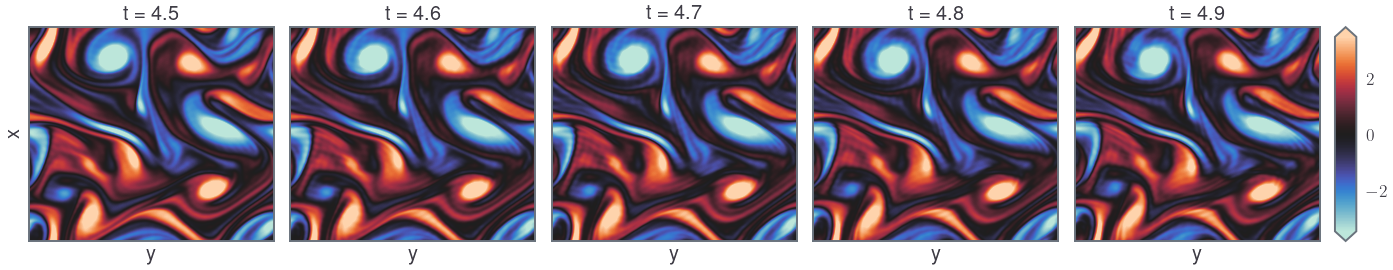

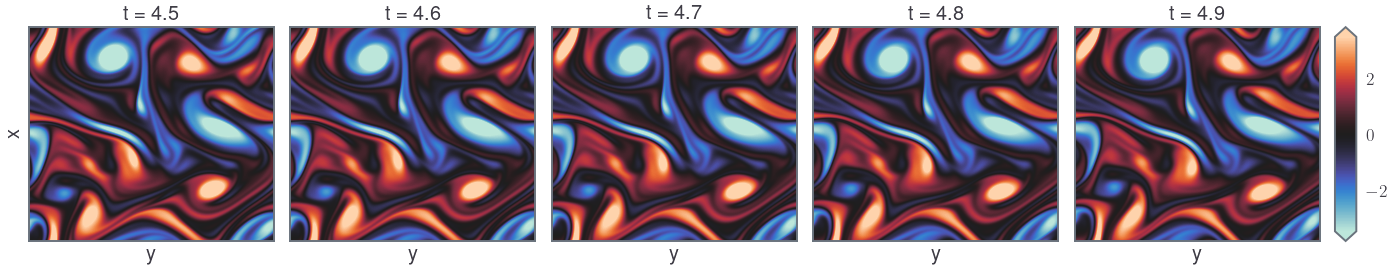

In [6]:
plot_contour_trajectory(preds_no[0].detach().cpu(), num_snapshots=5, T_start=4.5, dt=0.05)
plot_contour_trajectory(vort_out_gt[0].detach().cpu(), num_snapshots=5, T_start=4.5, dt=0.05)

In [9]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta).to(device)
model.load_state_dict(torch.load(path_model))
model.to(dtype)
f = torch.zeros((n, n))[None, ...].to(device)

In [18]:
l2_loss_setting = {
    "n_grid": n,
    "relative": True,
    "time_average": True,
    "diam": 2 * torch.pi,
    "freq_cutoff": n // 2 + 1,
}

res_loss_setting = {
    "n_grid": n,
    "relative": False,
    "time_average": True,
    "diam": 2 * torch.pi,
    "freq_cutoff": n // 2 + 1,
    "alpha": 10**(-3/2),
}

L2diff = SobolevLoss(**l2_loss_setting)
ResHm1Loss = SobolevLoss(norm_order=-1, **res_loss_setting)

modes_orig = (modes, modes, modes_t)
modes_ft = (64, 64, 6)
ft_kws = {"n_grid": n, 
          "dt": 1e-6,
          "delta": 1,
          "diam": 2*torch.pi,
          "finetune": True,
          "bdf_weight": (0.5, 0.5),
          }
torch.cuda.empty_cache()
qft = OutConvFT(*modes_orig, **ft_kws)
qft._update_spectral_conv_weights(*modes_ft, device=device, model=model.q)
qft.to(device).to(dtype)
optimizer = torch.optim.Adam([
            {'params': qft.conv.bias, 'lr': 1e-2},
            {'params': qft.conv.weight, 'lr': 1e-4},
        ])

In [20]:
l2diff_ft_gt = []
residual_hm1norms = []

num_iter = 100

with tqdm(total=num_iter) as pbar:
    for i in range(num_iter):
        qft.train()

        def closure():
            optimizer.zero_grad()
            preds_ft_all = qft(v_latent, vort_inp_gt, f, out_steps=T)
            res_ft_new = preds_ft_all["residual"]
            loss = ResHm1Loss(res_ft_new)
            loss.backward(retain_graph=True)
            return loss

        preds_ft_all = qft(v_latent, vort_inp_gt, f, out_steps=T)
        preds_ft = preds_ft_all["w"]
        res_ft = preds_ft_all["residual"]

        l2loss = L2diff(preds_ft, vort_out_gt)
        l2diff_ft = L2diff(preds_ft, preds_no)
        reshm1loss = ResHm1Loss(res_ft)

        optimizer.step(closure)
        optimizer.zero_grad()

        l2diff_ft_gt.append(l2loss.item())
        residual_hm1norms.append(reshm1loss.item())
        pbar.set_description(
            f"\|ft-gt\|: {l2loss.item():.3e} | \|no-ft\|: {l2diff_ft.item():.3e} | Res Hm1 : {reshm1loss.item():.3e}"
        )
        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

\|ft-gt\|: 1.616e-02 | \|no-ft\|: 3.411e-03 | Res Hm1 : 6.630e-06: 100%|██████████| 100/100 [00:02<00:00, 45.22it/s]


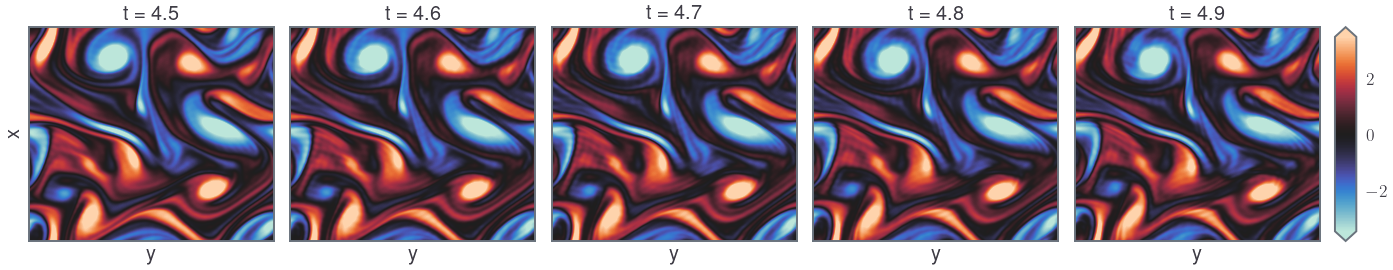

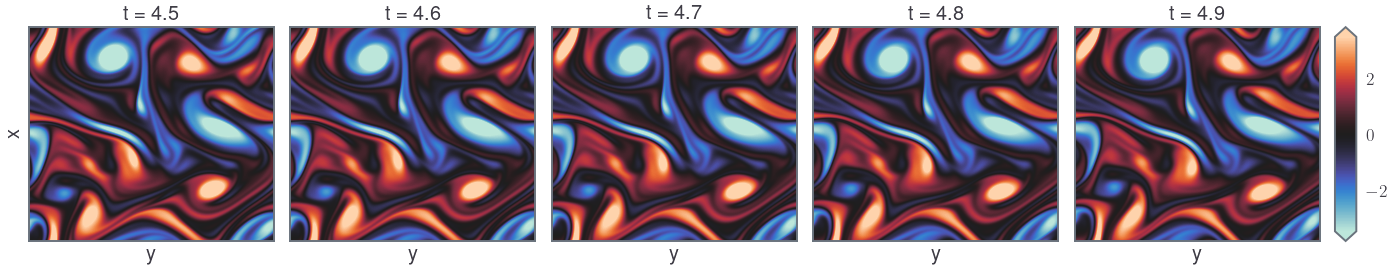

In [21]:
plot_contour_trajectory(preds_no[0].detach().cpu(), num_snapshots=5, T_start=4.5, dt=0.05)
plot_contour_trajectory(vort_out_gt[0].detach().cpu(), num_snapshots=5, T_start=4.5, dt=0.05)